In [24]:
!pip freeze | grep scikit-learn

scikit-learn @ file:///home/conda/feedstock_root/build_artifacts/scikit-learn_1685023695746/work


In [25]:
import sklearn
print(sklearn.__version__)

1.2.2


In [3]:
!python -V

Python 3.10.11


In [25]:
import os
import pickle
import pandas as pd
import numpy as np

In [17]:
# this one errors out - use ../models/lin_reg.bin from the first leasson instead
# !wget https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/cohorts/2023/04-deployment/homework/model.bin

--2023-06-17 09:09:02--  https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/cohorts/2023/04-deployment/homework/model.bin
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘model.bin.1’

model.bin.1             [ <=>                ] 139.70K  --.-KB/s    in 0.008s  

2023-06-17 09:09:02 (18.1 MB/s) - ‘model.bin.1’ saved [143050]



In [14]:
## this is the best model from the second module - not used here either
#import boto3
#import pickle

## s3://sparkhudi/mlflow/52560e9443854b24b3bdc3cab6017dc2/artifacts/models/nyc-taxi-experiment/model.bin

## Set up S3 client
#s3 = boto3.client('s3')

## S3 bucket and file details
#bucket_name = 'sparkhudi'
#file_key = 'mlflow/52560e9443854b24b3bdc3cab6017dc2/artifacts/models/nyc-taxi-experiment/model.bin'

## Download the file from S3
#s3.download_file(bucket_name, file_key, 'model.bin')

## Load the model using pickle
#with open('model.bin', 'rb') as f_in:
#    # dv, model = pickle.load(f_in)
#    objects = pickle.load(f_in)

## Extract individual objects from the list/tuple
#print(len(objects))
#dv = objects[0]
#print(objects[1])
#model = objects[2]

3
[0.   0.   4.6  ... 0.   2.17 7.23]


In [18]:
def fetch_ios(year: int=2022, month: int=2, taxi_type: str="green"):
    # year = 2022
    # month = 2
    # taxi_type = 'green'
    # input_file = f'https://s3.amazonaws.com/nyc-tlc/trip+data/{taxi_type}_tripdata_{year:04d}-{month:02d}.parquet'
    
    input_url = f'https://d37ci6vzurychx.cloudfront.net/trip-data/{taxi_type}_tripdata_{year:04d}-{month:02d}.parquet'
    output_file = f'./tripdata/{taxi_type}/{year:04d}-{month:02d}.parquet'
    
    return input_url, output_file

def read_data(filename: str):
    categorical = ['PULocationID', 'DOLocationID']
    df = pd.read_parquet(filename)
    print(df.head())

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60
    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()
    
    df['ride_id'] = df['lpep_pickup_datetime'].dt.strftime('%Y/%m_') + df.index.astype('str')
    df[categorical] = df[categorical].fillna(-1).astype('int').astype('str')

    return df

def load_model():
    with open('./models/lin_reg.bin', 'rb') as f_in:
        dv, model = pickle.load(f_in)
    return dv, model

In [19]:
def apply_model(input_url):

    categorical = ['PULocationID', 'DOLocationID']
    df = read_data(input_url)
    # df to dicts
    dicts = df[categorical].to_dict(orient='records')
    dv, model = load_model()

    X_val = dv.transform(dicts)
    y_pred = model.predict(X_val)
    return model.predict(X_val), df

In [20]:
input_url, output_file = fetch_ios()
predictions, df = apply_model(input_url)
std_dev = np.std(predictions)
mean = np.mean(predictions)
print("Prediction Standard Deviation:", std_dev)
print("Prediction Mean:", mean)
df['prediction'] = predictions

   VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2022-02-01 00:20:21   2022-02-01 00:24:30                  N   
1         2  2022-02-01 00:32:26   2022-02-01 00:35:31                  N   
2         1  2022-02-01 00:17:27   2022-02-01 00:44:44                  N   
3         2  2022-02-01 00:45:37   2022-02-01 01:27:16                  N   
4         2  2022-02-01 00:06:46   2022-02-01 00:30:06                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         1.0            43           238              1.0           1.16   
1         1.0           166            24              1.0           0.57   
2         1.0           226           219              1.0           0.00   
3         1.0            89            83              1.0          16.62   
4         1.0             7           238              1.0           5.97   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount ehail_fee  \
0   

In [ ]:
#q1: Standard Deviation: 5.264614073338433

In [23]:
def save_predictions_to_file(df, output_file):
# this has been done on read 
#df['ride_id'] = df['tpep_pickup_datetime'].dt.strftime('%Y/%m_') + df.index.astype('str')

    directory = os.path.dirname(output_file)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    df_result = df[['ride_id','prediction']]
    df_result.to_parquet(
        output_file,
        engine='pyarrow',
        compression=None,
        index=False
    )
    

In [26]:
save_predictions_to_file(df, output_file)

In [33]:
#q2 -57.2 mb

In [38]:
# df_result.head()

,ride_id,prediction
0,2022/02_0,19.328296
1,2022/02_1,23.009960
2,2022/02_2,35.245256
3,2022/02_3,25.264443
4,2022/02_4,21.707136


In [ ]:
#q3 jupyter nbconvert --to script stutter.ipynb
# with File -> open -> terminal (it is running in docker container, jupyter installation is only available within the container)
# jupyter nbconvert --to script stutter.ipynb
# run in the terminal in the dir where jupyter notebook is located - output stutter.py file

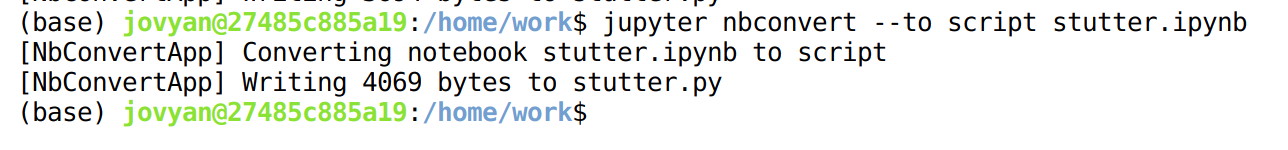

In [ ]:
#q4 pipenv install scikit-learn==1.2.2
# scikit-learn hash: 29ab751cef62b24e21ef7e072351920526f44aa7bbc4e937b04acd054a71e64d

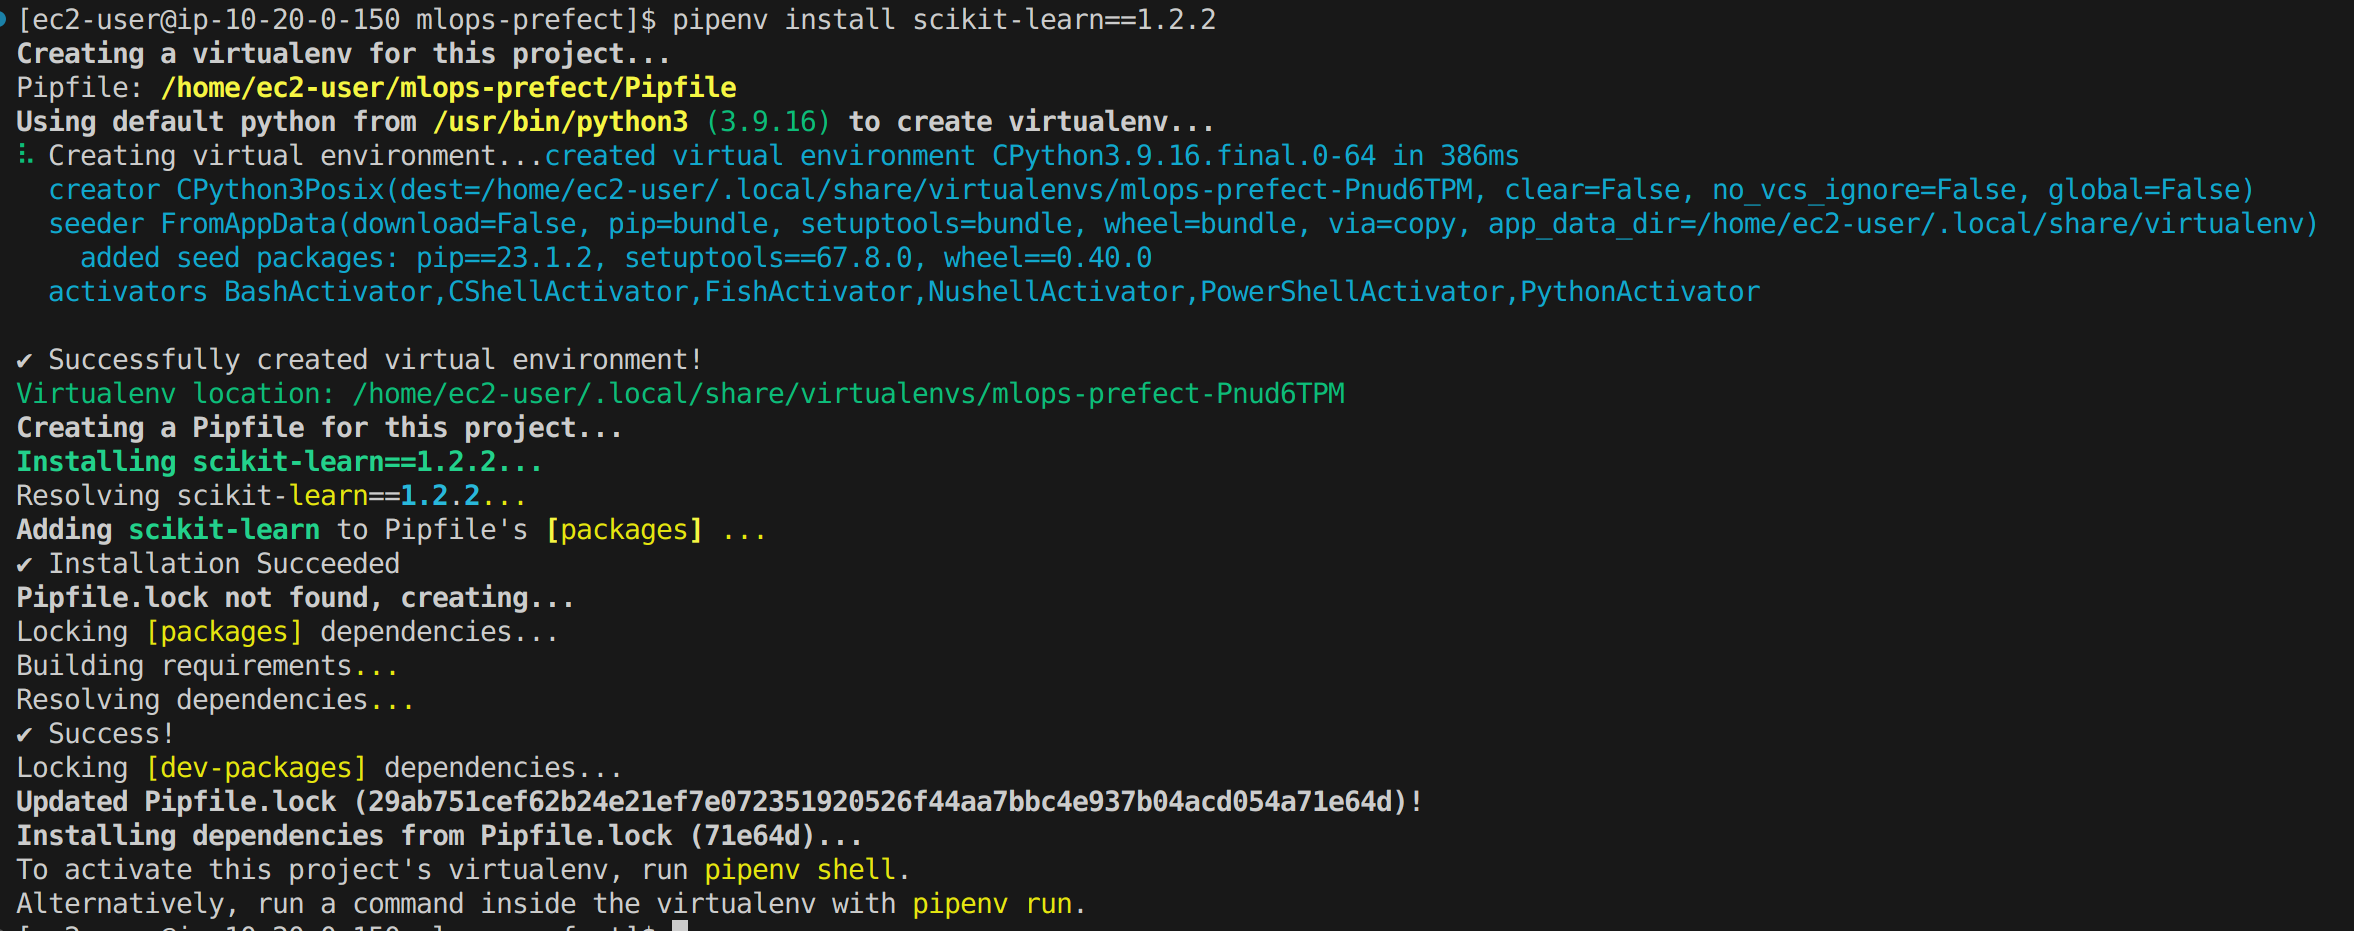

In [ ]:
#q5: using March-2022 green trip data: 
# python3 jupyter/stutter.py --year 2022 --month 3 --taxi_type green
# mean predicted duration - 16.186 (using diff model from the one in lesson's repo - that one doesn't load)

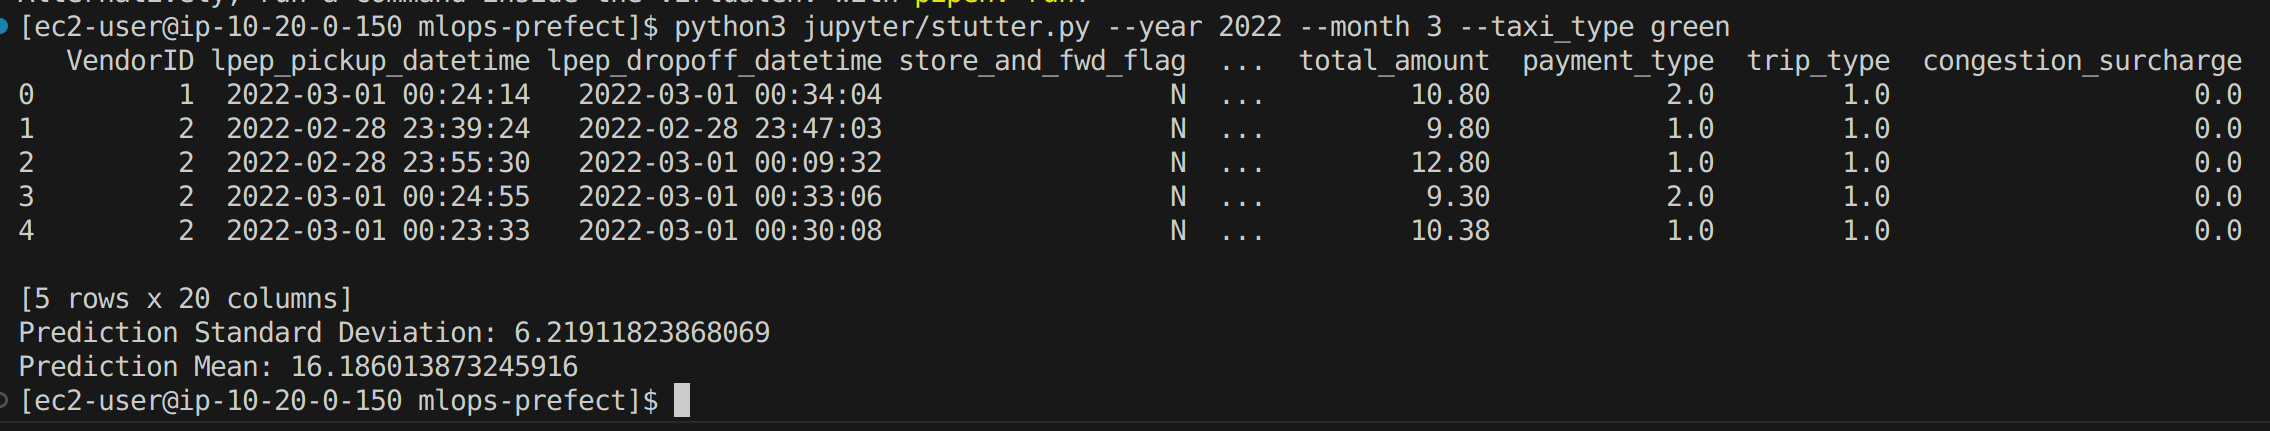

In [ ]:
#q6: mean predicted duration for April 2022: 12.185

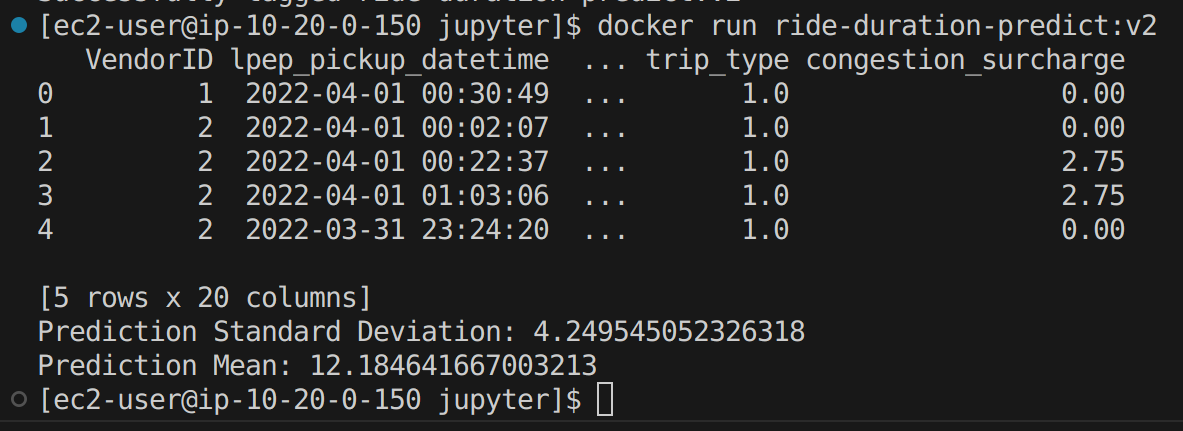